# Gravitar: Reinforcement Learning Summative Assignment

In [3]:
# This is a PPO agent which uses hyperparameters given in the paper 'Proximal 
# Policy Optimization Algorithms' [https://arxiv.org/abs/1707.06347].
# This code is based on https://github.com/seungeunrho/minimalRL/blob/master/ppo.py,
# which is released under the MIT License.
# The CNN and state buffer are based on the tutorial, 'DQN with CNN: Recreating the Google DeepMind Network',
# [https://github.com/hubbs5/rl_blog/blob/master/q_learning/deep/dqn_cnn.py]
# by Christian Hubbs.

# Abstract:
# I chose to implement PPO as I believed it struck a nice balance between
# architectural simplicity and performance in Gravitar. Looking at the paper,
# the agent attained a mean final score of 737.2, which outperformed A2C's 
# score of 194.0, ACER's score of 225.3, and also DQN's score of 306.7. I 
# began by getting minimalRL's code to work on the Cartpole environment, and 
# then trying the exisiting fully-connected policy with Gravitar-ram. Thinking 
# that training on just RAM, would be limiting, I replaced the existing policy
# with a CNN policy from the DQN paper, including implementing a state buffer
# that would store 4 frames at a time, so that the agent could then track 
# direction and velocity. After training for 4000 episodes, my agent has gotten
# stuck in a local minimum, where it has taught itself to navigate the world,
# but not shoot, so it simply floats around until it crashes. This could be due
# to the learning rate being too high, and a gradient that has vanished means
# that it is almost impossible for the agent to get out of it and explore new 
# actions. There is an increase in mean score between the 2000 and 2500 episode
# mark, but that eventually declines again to 0. There is the possibility that
# the agent will escape this behaviour and converge to a high score, but I have
# been able to train the agent for a long enough period of time to find out. 

## Google Drive Integration

Mount Google Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

## Setup

Import modules.

In [1]:
import gym
import numpy as np
import random
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.distributions import Categorical

import cv2

from skimage import transform

from collections import deque

from copy import deepcopy

Set device.

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device: ', device)

device:  cpu


Set environment.

In [3]:
env = gym.make('Breakout-v0')

Set seed for reproducible environment and action spaces

In [4]:
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

[742]

## Environment preview

View initial state.

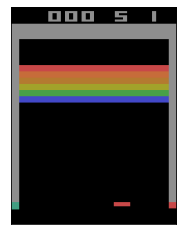

In [5]:
state = env.reset()

plt.imshow(state)
plt.xticks([])
plt.yticks([])
plt.show()

View initial state dimensions.

In [6]:
print(state.shape)

(210, 160, 3)


View action and observation space.

In [7]:
print('action space: ', env.action_space)
print('no. actions: ', env.action_space.n)
print('obervation space: ', env.observation_space)

action space:  Discrete(4)
no. actions:  4
obervation space:  Box(0, 255, (210, 160, 3), uint8)


View next state, having taken a random action.

random action:  0


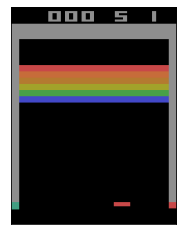

In [8]:
rand_act = env.action_space.sample()
print('random action: ', rand_act)
s_prime = env.step(rand_act)[0]

plt.imshow(s_prime)
plt.xticks([])
plt.yticks([])
plt.show()

View number of lives left.

In [9]:
print('lives left: ', env.step(rand_act)[3]['ale.lives'])

lives left:  5


## Frame pre-processing

Reset environment.

In [10]:
s = env.reset()

### Convert to greyscale.

In [11]:
shape_before = s.shape
print("shape before transformation: ", shape_before)
s = cv2.cvtColor(s, cv2.COLOR_RGB2GRAY)
shape_after = s.shape
print("shape after transformation:  ", shape_after)

shape before transformation:  (210, 160, 3)
shape after transformation:   (210, 160)


View greyscale frame.

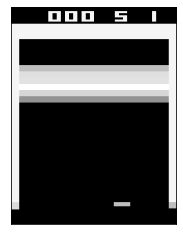

In [12]:
plt.imshow(s, cmap=plt.get_cmap('gray'))
plt.xticks([])
plt.yticks([])
plt.show()

### Crop out score and lives remaining 

shape before crop:  (210, 160, 3)
shape after crop:   (187, 160, 3)


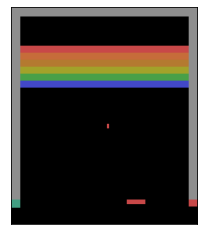

In [13]:
rand_act = env.action_space.sample()
s_prime = env.step(rand_act)[0]
s = s_prime
print('shape before crop: ', s.shape)
s = s[23:]
print('shape after crop:  ', s.shape)

# view cropped frame
plt.imshow(s)
plt.xticks([])
plt.yticks([])
plt.show()

### Resize to 84 x 84.

In [14]:
shape_before = s.shape
print("shape before transformation: ", shape_before)
s = transform.resize(s, (84, 84))
shape_after = s.shape
print("shape after transformation:  ", shape_after)

shape before transformation:  (187, 160, 3)
shape after transformation:   (84, 84, 3)


View resized frame.

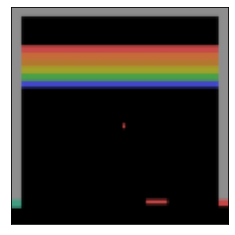

In [15]:
plt.imshow(s, cmap=plt.get_cmap('gray'))
plt.xticks([])
plt.yticks([])
plt.show()

### Define function to apply pre-processing steps.

In [16]:
def preprocess(s):
  s = cv2.cvtColor(s, cv2.COLOR_RGB2GRAY)
  s = s[23:]
  s = transform.resize(s, (84, 84))
  return s

View pre-processed next state, having taken a random action. 

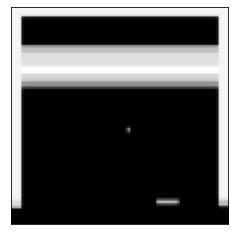

In [17]:
rand_act = env.action_space.sample()
s_prime = env.step(rand_act)[0]
s_prime = preprocess(s_prime)

plt.imshow(s_prime, cmap=plt.get_cmap('gray'))
plt.xticks([])
plt.yticks([])
plt.show()

## State buffer

### Create state buffer to store 4 consecutive frames.

Set hyper parameters.

`tau`: Size of the state buffer.

`input_dim`: Dimension of the frames stored by the state buffer.

In [18]:
tau = 4
input_dim = (84, 84)

Initialise the state buffer with zeros of dimension 84 x 84..

In [19]:
state_buffer = deque(maxlen=tau)
print('state buffer length before: ', len(state_buffer))
for i in range(tau):
  state_buffer.append(np.zeros(input_dim))
print('state buffer length after:  ', len(state_buffer))

state buffer length before:  0
state buffer length after:   4


### Stack state buffer to form a batch.

In [20]:
buffer_stack = np.stack([state_buffer])
print('stack shape: ', buffer_stack.shape)

stack shape:  (1, 4, 84, 84)


### View state buffer contents

View initial state.

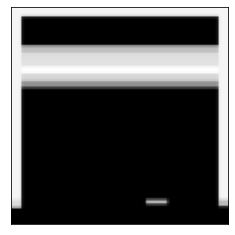

In [21]:
s = preprocess(env.reset())

plt.imshow(s, cmap=plt.get_cmap('gray'))
plt.xticks([])
plt.yticks([])
plt.show()

View initialised states in state buffer.

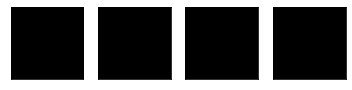

In [22]:
s_buffer = deque(maxlen=tau)
s_prime_buffer = deque(maxlen=tau)
for i in range(tau):
  s_buffer.append(np.zeros((84, 84)))
  s_prime_buffer.append(np.zeros((84, 84)))

def show_buffer(s_buffer):
  for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(s_buffer[i], cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
  plt.show()

show_buffer(s_buffer)

Show state buffer after adding initial state.

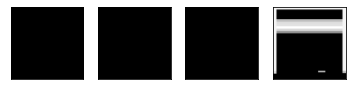

In [23]:
s_buffer.append(s)

show_buffer(s_buffer)

Show state buffer each time after a random action.

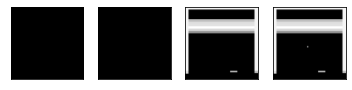

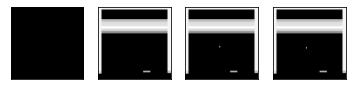

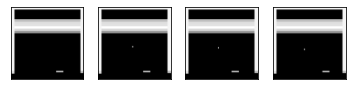

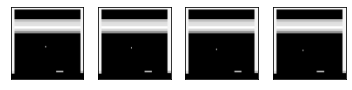

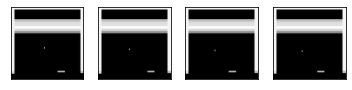

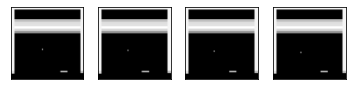

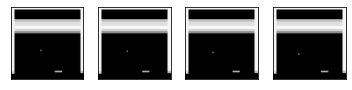

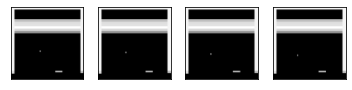

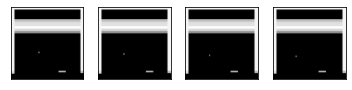

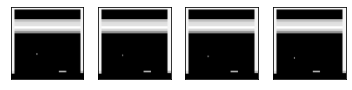

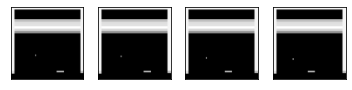

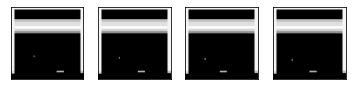

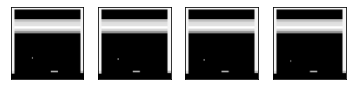

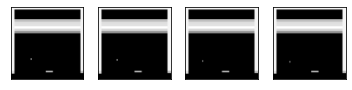

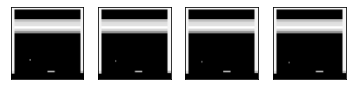

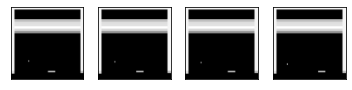

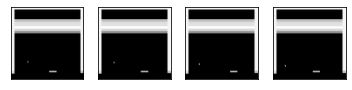

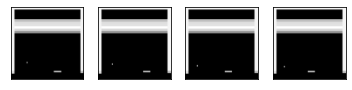

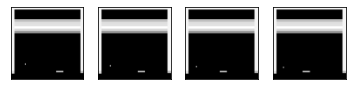

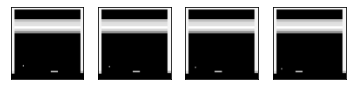

In [24]:
for i in range(20):
  rand_act = env.action_space.sample()
  s, r, done, info = env.step(rand_act)
  s = preprocess(s)
  s_buffer.append(s)

  show_buffer(s_buffer)

## Model definition

### Define CNN layer.

In [25]:
cnn = nn.Sequential(
    nn.Conv2d(tau, 32, kernel_size=8, stride=4),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, stride=1),
    nn.ReLU()
    )

Send network to device and print.

In [26]:
cnn.to(device)

Sequential(
  (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
)

Feed state buffer stack through CNN layer.

In [27]:
cnn_out = cnn(torch.FloatTensor(buffer_stack).to(device))
print('shape of CNN output: ', cnn_out.shape)

shape of CNN output:  torch.Size([1, 64, 7, 7])


Flatten CNN layer output, and print.

In [28]:
fc_input_dim = cnn_out.flatten().shape[0]
print('fully connecetd layer input size: ', fc_input_dim)

fully connecetd layer input size:  3136


### Define fully-connected (fc) policy layer.

In [29]:
fc_pi = nn.Sequential(
    nn.Linear(fc_input_dim, 512, bias=True),
    nn.ReLU(),
    nn.Linear(512, env.action_space.n))

Send network to device, and print.

In [30]:
fc_pi.to(device)

Sequential(
  (0): Linear(in_features=3136, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=4, bias=True)
)

Reshape CNN layer output, then feed through fc layer.

In [31]:
shape_before = cnn_out.shape
print('shape before reshape: ', shape_before)
fc_input = cnn_out.reshape(-1, fc_input_dim)
print('shape after reshape:  ', fc_input.shape)

shape before reshape:  torch.Size([1, 64, 7, 7])
shape after reshape:   torch.Size([1, 3136])


View fc policy layer output.

In [32]:
fc_output = fc_pi(fc_input)
fc_output

tensor([[-0.0169, -0.0378,  0.0508,  0.0013]], grad_fn=<AddmmBackward>)

View fc layer output shape to obtain softmax dimension.

In [33]:
print(fc_output.shape)

torch.Size([1, 4])


We want the sum of action probabilities to equal 1. The porbabilities come from the values on the last axis (axis 1).

In [34]:
softmax_dim = 1

Obtain action probabilities from values.

In [35]:
prob = F.softmax(fc_output, dim=softmax_dim)
prob

tensor([[0.2458, 0.2408, 0.2631, 0.2504]], grad_fn=<SoftmaxBackward>)

Turn action probabilities into a categorical distribution.

> 'A categorical distribution is a discrete probability distribution that describes the possible results of a random variable that can take on one of K possible categories, with the probability of each category separately specified' &mdash; Wikipedia

In [36]:
m = Categorical(prob)
m

Categorical(probs: torch.Size([1, 4]))

Sample an action from the categorical distribution.

In [37]:
a = m.sample().item() # .item() converts it from tensor to int
a

0

### Define fully connected (fc) value layer.

In [38]:
fc_v  = nn.Sequential(
    nn.Linear(fc_input_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 1))

Send network to device, and print

In [39]:
fc_v.to(device)

Sequential(
  (0): Linear(in_features=3136, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1, bias=True)
)

View fc value layer output.

In [40]:
fc_out = fc_v(fc_input)
fc_out

tensor([[0.0073]], grad_fn=<AddmmBackward>)

### Define functions

Define a function to pass a state buffer stack through the network and obtain action probabilities.

In [41]:
def pi(x):
  x_t = torch.FloatTensor(x).to(device)
  cnn_out = cnn(x_t)
  fc_in = cnn_out.reshape(-1, fc_input_dim)
  fc_out = fc_pi(fc_in)
  prob = F.softmax(fc_out, dim=softmax_dim)
  return prob

Check `pi` output.

In [42]:
pi(buffer_stack)

tensor([[0.2458, 0.2408, 0.2631, 0.2504]], grad_fn=<SoftmaxBackward>)

In [43]:
def v(x):
  x_t = torch.FloatTensor(x).to(device)
  cnn_out = cnn(x_t)
  fc_in = cnn_out.reshape(-1, fc_input_dim)
  v = fc_v(fc_in)
  return v

Check `v` output.

In [44]:
v(buffer_stack)

tensor([[0.0073]], grad_fn=<AddmmBackward>)

## Checks

Check contents of `s_buffer` and `s_prime_buffer`.

s


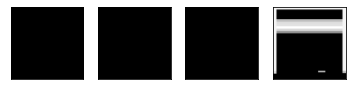

s_prime


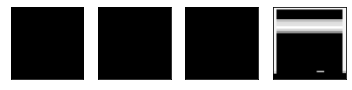

s


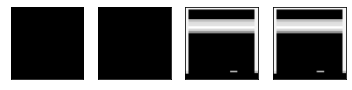

s_prime


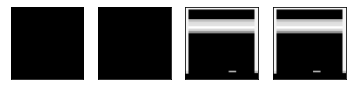

s


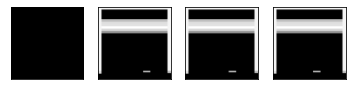

s_prime


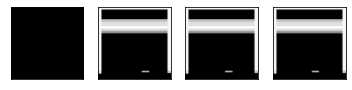

s


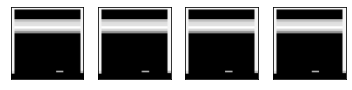

s_prime


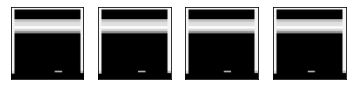

s


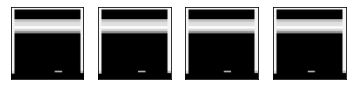

s_prime


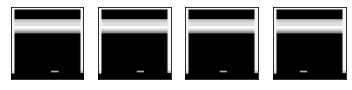

In [45]:
s = preprocess(env.reset())

s_buffer = deque(maxlen=tau)
s_prime_buffer = deque(maxlen=tau)
for i in range(tau):
  s_buffer.append(np.zeros((84, 84)))
  s_prime_buffer.append(np.zeros((84, 84)))

for t in range(5): 
  s_buffer.append(s)
  print('s')
  show_buffer(s_buffer)
  a = env.action_space.sample()
  s_prime, r, done, info = env.step(a)
  s_prime = preprocess(s_prime)
  s_prime_buffer.append(s_prime)
  print('s_prime')
  show_buffer(s_prime_buffer)
  s = s_prime

Get probability as float from tensor.

In [46]:
prob = pi(buffer_stack)
m = Categorical(prob)
a = m.sample().item()
print(prob)
print('action: ', a)
print('action probability: ', prob.cpu().detach().numpy()[0][a])

tensor([[0.2458, 0.2408, 0.2631, 0.2504]], grad_fn=<SoftmaxBackward>)
action:  2
action probability:  0.26305863


## Proximal Policy Optimisation (PPO)

In [47]:
# hyperparameters
learning_rate = 2.5e-4
gamma         = 0.99
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        
        self.cnn = nn.Sequential(
            nn.Conv2d(tau, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
            )
        
        self.fc_pi = nn.Sequential(
            nn.Linear(fc_input_dim, 512, bias=True),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n)
            )
        
        self.fc_v  = nn.Sequential(
            nn.Linear(fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
            )
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim=1):
        cnn_out = self.cnn(x).reshape(-1, fc_input_dim)
        prob = F.softmax(self.fc_pi(cnn_out), dim=softmax_dim)
        return prob
    
    def v(self, x):
        cnn_out = self.cnn(x).reshape(-1, fc_input_dim)
        v = self.fc_v(cnn_out)
        return v

    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float, device=device), torch.tensor(a_lst, device=device), \
                                          torch.tensor(r_lst, device=device), torch.tensor(s_prime_lst, dtype=torch.float, device=device), \
                                          torch.tensor(done_lst, dtype=torch.float, device=device), torch.tensor(prob_a_lst, device=device)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a
        
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.cpu().detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float, device=device)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)
    plt.show()

## Training loop and results

← You can download the videos from the videos folder in the files on the left

marking, episode: 0, score: 0.0, mean_score: 0.00, std_score: 0.00


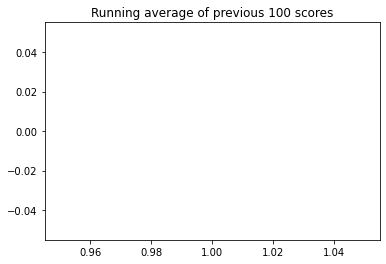

episode:  10 score 2.0 mean_score: 1.73 time_steps 3073 learning_steps 30
episode:  20 score 5.0 mean_score: 1.67 time_steps 5865 learning_steps 57
episode:  30 score 0.0 mean_score: 1.74 time_steps 8955 learning_steps 87
episode:  40 score 2.0 mean_score: 1.73 time_steps 11947 learning_steps 116
episode:  50 score 1.0 mean_score: 1.63 time_steps 14346 learning_steps 139
episode:  60 score 2.0 mean_score: 1.57 time_steps 16778 learning_steps 163


KeyboardInterrupt: 

In [48]:
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda episode_id: (episode_id%video_every)==0,force=True)

# hyperparameters
T_horizon     = 128
video_every   = 100
print_every   = 10
n_games = 5000

model = PPO().to(device)

figure_file = 'figure.png'

score_history = []
marking  = []
learn_iters = 0
avg_score = 0
n_steps = 0

for n_episode in range(n_games+1):
    s = preprocess(env.reset())
    s_buffer = deque(maxlen=tau)
    s_prime_buffer = deque(maxlen=tau)
    for i in range(tau):
      s_buffer.append(np.zeros((84, 84)))
      s_prime_buffer.append(np.zeros((84, 84)))
    
    done = False
    score = 0.0
    while not done: # while episode is not over
        for t in range(T_horizon): # no. steps before update
            s_buffer.append(s)
            s_stack = np.stack([s_buffer])
            
            prob = model.pi(torch.FloatTensor(s_stack).to(device))
            m = Categorical(prob)
            a = m.sample().item()
            s_prime, r, done, info = env.step(a)
            s_prime = preprocess(s_prime)
            s_prime_buffer.append(s_prime)

            model.put_data((deepcopy(s_buffer), 
                            a, 
                            r, 
                            deepcopy(s_prime_buffer), 
                            prob.cpu().detach().numpy()[0][a], 
                            done))
            s = s_prime

            n_steps += 1
            score += r
            if done:
              break

        model.train_net()
        learn_iters += 1
    
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []

        x = [i+1 for i in range(len(score_history))]
        plot_learning_curve(x, score_history, figure_file)

    # you can change this part, and print any data you like (so long as it doesn't start with "marking")
    if n_episode%print_every==0 and n_episode!=0:
        print('episode: ', n_episode, 'score %.1f' % score, 'mean_score: %.2f' % avg_score,
        'time_steps', n_steps, 'learning_steps', learn_iters)